<a href="https://colab.research.google.com/github/ekttd/VAST-Challenge/blob/main/VAST_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Загрузка данных**

In [ ]:
import pandas as pd

In [ ]:
friday_url = "https://github.com/ekttd/VAST-Challenge/raw/main/MC2%202015%20Data/comm-data-Fri.csv"
df = pd.read_csv(friday_url)
df.head()

,Timestamp,from,to,location
0,2014-6-06 08:03:19,439105,1053224,Kiddie Land
1,2014-6-06 08:03:19,439105,1696241,Kiddie Land
2,2014-6-06 08:03:19,439105,580064,Kiddie Land
3,2014-6-06 08:03:19,439105,1464748,Kiddie Land
4,2014-6-06 08:03:47,1836139,1593258,Entry Corridor


# **Преобразование данных**

---
Добавлены интервалы по 15 минут для визуалаизации


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# вообще Timestamp и так был datetime, но почему-то
# без явного преобразования дальше не работает(

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
start_time = df['Timestamp'].iloc[0]

start_hour = start_time.floor('h') # округление до начала часа
# сколько минут прошло от первой записи
minutes_from_start = (df['Timestamp'] - start_hour).dt.total_seconds() // 60

# метка интервала - делим всю колонку на 15, получается номер интервала
df['quarter'] = (minutes_from_start // 15 + 1).astype(int)

df[1430:1440]

,Timestamp,from,to,location,quarter
1430,2014-06-06 08:14:53,824453,148882,Kiddie Land,1
1431,2014-06-06 08:14:53,1371106,1846280,Kiddie Land,1
1432,2014-06-06 08:14:56,973062,196239,Entry Corridor,1
1433,2014-06-06 08:14:56,973062,919935,Entry Corridor,1
1434,2014-06-06 08:14:58,96972,1607917,Entry Corridor,1
1435,2014-06-06 08:14:58,96972,1205461,Entry Corridor,1
1436,2014-06-06 08:14:58,96972,1492555,Entry Corridor,1
1437,2014-06-06 08:15:00,643918,918404,Wet Land,2
1438,2014-06-06 08:15:01,755524,217150,Tundra Land,2
1439,2014-06-06 08:15:01,755524,947320,Tundra Land,2


In [ ]:
df['hour'] = df['Timestamp'].dt.hour
df['minute'] = df['Timestamp'].dt.minute
df = df.drop(columns=['Timestamp'])
df.head()

,from,to,location,quarter,hour,minute
0,439105,1053224,Kiddie Land,1,8,3
1,439105,1696241,Kiddie Land,1,8,3
2,439105,580064,Kiddie Land,1,8,3
3,439105,1464748,Kiddie Land,1,8,3
4,1836139,1593258,Entry Corridor,1,8,3


In [ ]:
# количество сообщений в каждую четверть
quarters_intence = df['quarter'].value_counts().sort_index()
quarters_intence.head()

,count
quarter,
1,1437
2,5029
3,7539
4,10679
5,12377


In [ ]:
values = quarters_intence.values
intervals = quarters_intence.index

start_minutes = df.loc[0, 'hour'] * 60 + df.loc[0, 'minute']

labels = []

for q in intervals:
    start_time = start_hour + pd.Timedelta(minutes=(q - 1) * 15)
    end_time = start_time + pd.Timedelta(minutes=15)

    labels.append(
        f"{start_time.strftime('%H:%M')}-{end_time.strftime('%H:%M')}"
    )

if values.max() == values.min():
    norm = np.zeros_like(values)
else:
    norm = (values - values.min()) / (values.max() - values.min())

colors = plt.cm.YlOrRd(norm)

equal_parts = np.ones(len(values))

## Круговая диаграмма с легендой

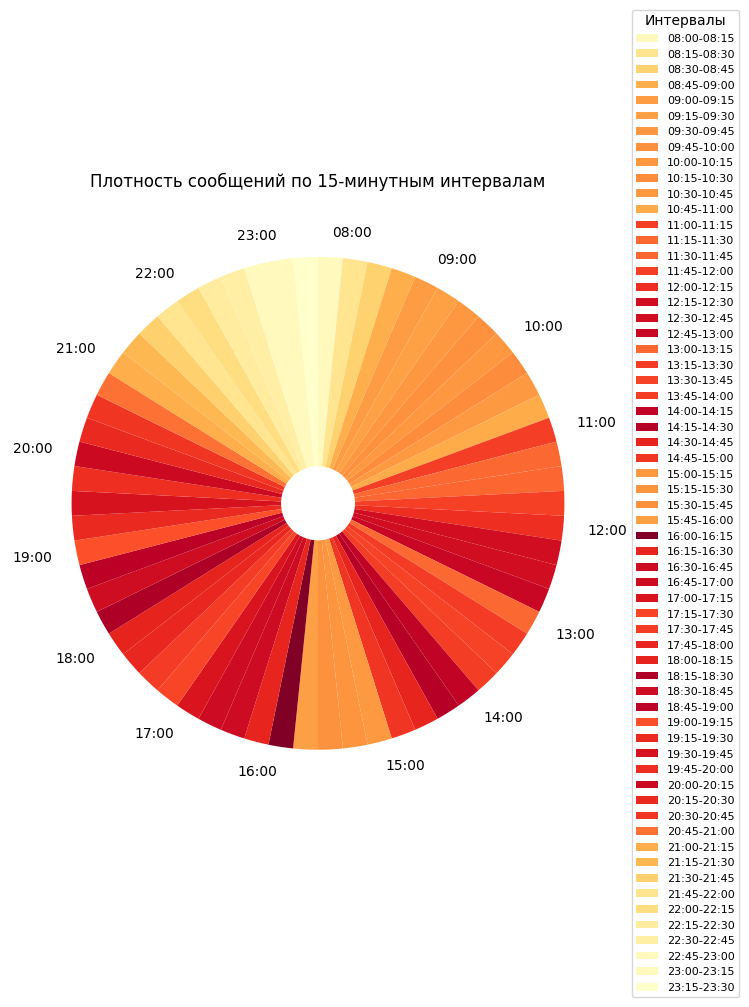

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

step_for_clock_labels = 4
clock_labels = [
    (start_hour + pd.Timedelta(minutes=(q-1)*15)).strftime('%H:%M')
    if (q-1) % step_for_clock_labels == 0 else ""
    for q in intervals
]

wedges, _ = ax.pie(
    equal_parts,
    labels=clock_labels,
    colors=colors,
    wedgeprops=dict(width=0.85),
    counterclock=False,
    startangle=90
)
ax.legend(
    wedges,
    labels,
    title="Интервалы",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=8
)


plt.title("Плотность сообщений по 15-минутным интервалам")

plt.show()

## Просто круговая диаграмма

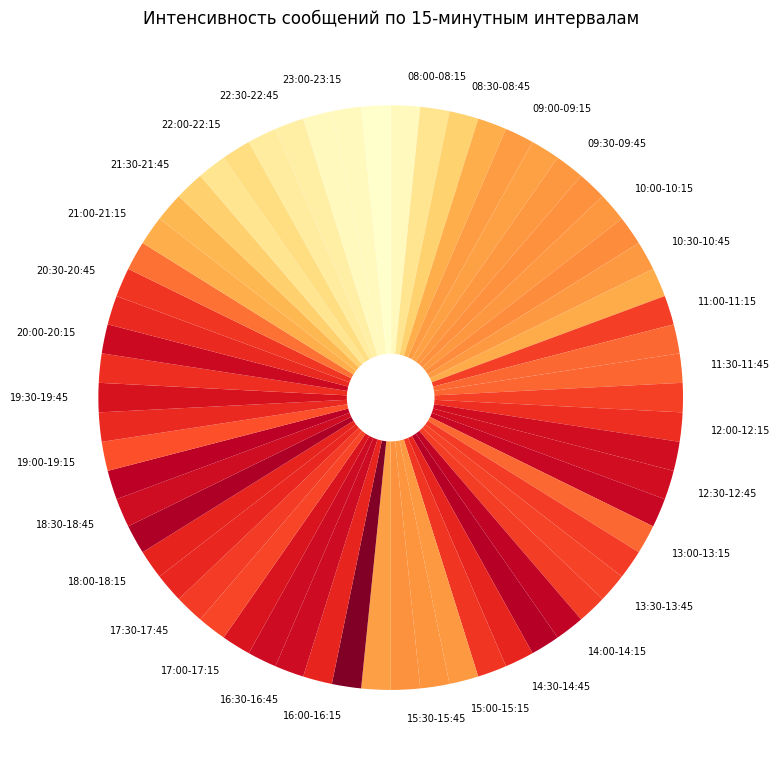

In [ ]:
step = 2

filtered_labels = [
    label if i % step == 0 else ""
    for i, label in enumerate(labels)
]

plt.figure(figsize=(8, 8))

plt.pie(
    equal_parts,
    labels=filtered_labels,
    colors=colors,
    wedgeprops=dict(width=0.85),
    counterclock=False,
    startangle=90,
    textprops={'fontsize': 7}
)

plt.title("Интенсивность сообщений по 15-минутным интервалам")
plt.tight_layout()
plt.show()

# Сообщения в локациях

In [ ]:
# количество сообщений в каждой локации
location_counts = df.groupby('location').size().sort_values(ascending=False)
location_counts.head()

,0
location,
Wet Land,353319
Entry Corridor,191229
Tundra Land,172764
Coaster Alley,117934
Kiddie Land,113493


In [ ]:
# Координаты локаций на карте (в пикселях)

areas = {
    "Tundra Land": (0, 0, 2033, 1800),
    "Entry Corridor": (2040, 0, 2930, 1801),
    "Kiddie Land": (2925, 0, 4041, 1430),
    "Wet Land": (0, 1780, 3313, 2694),
    "Coaster Alley": [(0, 2710, 4020, 2968), (3325, 1418, 4037, 2968)]
}

In [ ]:
values = location_counts.values
norm = (values - values.min()) / (values.max() - values.min())

zone_intensity = dict(zip(location_counts.index, norm))

In [ ]:
import random

# Генерация случайной точки внутри локации
def random_point(area):
    if isinstance(area, list):
        area = random.choice(area)
    x1, y1, x2, y2 = area
    return random.uniform(x1, x2), random.uniform(y1, y2)

In [ ]:
sample_fraction = 0.001
df_sample = df.sample(frac=sample_fraction, random_state=42)

cmap = plt.cm.YlOrRd

xs = []
ys = []
colors = []

for loc in df_sample["location"]:
    if loc in areas:
        x, y = random_point(areas[loc])
        xs.append(x)
        ys.append(y)

        intensity = zone_intensity[loc]
        colors.append(cmap(intensity))

In [ ]:
import requests
from PIL import Image
from io import BytesIO

map_url = "https://github.com/ekttd/VAST-Challenge/raw/main/MC2%202015%20Data/map.jpg"
response = requests.get(map_url)
img = Image.open(BytesIO(response.content))

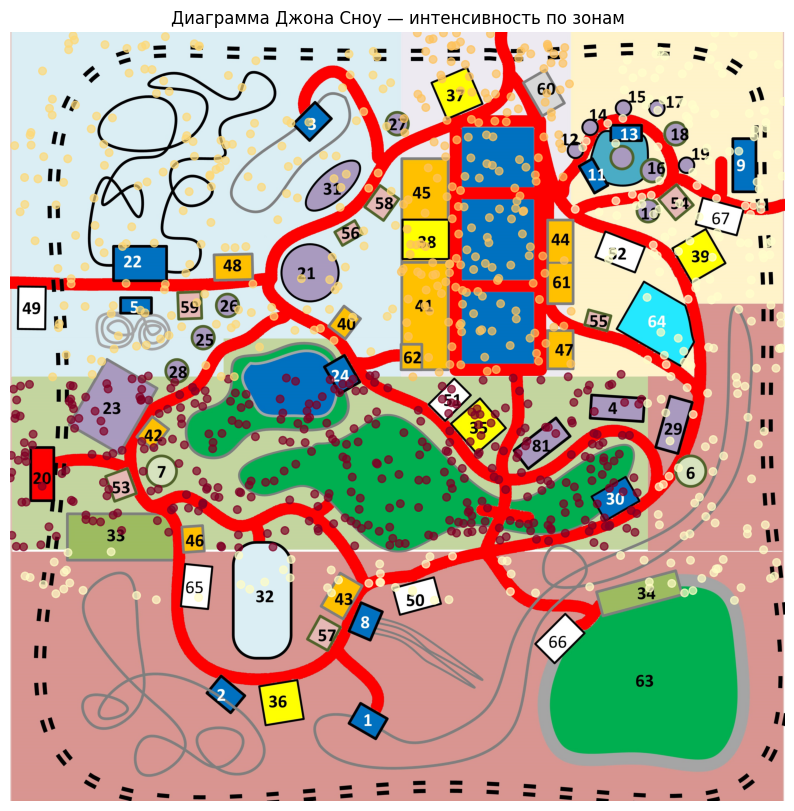

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img)

plt.scatter(
    xs,
    ys,
    c=colors,
    s=30,
    alpha=0.7
)

plt.title("Диаграмма Джона Сноу — интенсивность по зонам")
plt.axis("off")
plt.show()